In [1]:
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from google.cloud import bigquery
from tensorflow.keras.callbacks import ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow_io.bigquery import BigQueryClient
from tensorflow_io.bigquery import BigQueryReadSession
from tensorflow.python.framework import dtypes

from tensorflow import feature_column

In [3]:
from tensorflow.keras import layers, losses, optimizers

In [4]:
def features_and_labels(features):
    target = features.pop('s1')
    #enodeb = features.pop('enodeb')
    return features, target

def read_bigquery():
    batch_size=5
    tensorflow_io_bigquery_client = BigQueryClient()
    read_session = tensorflow_io_bigquery_client.read_session(
          "projects/" + PROJECT_ID,
           PROJECT_ID, TABLE_ID, DATASET_ID, COL_NAMES, COL_TYPES,
          requested_streams=2)

    dataset = read_session.parallel_read_rows()
    transformed_ds = dataset.map(features_and_labels).shuffle(batch_size*10).batch(batch_size)
    return transformed_ds

In [5]:
def create_window_list(NB_LAG):
    window_list = []
    for l in range(NB_LAG):
        if l<NB_LAG:
            window_list.append(f't_{NB_LAG-l}')
    return window_list

l = create_window_list(4)

COL_TYPES = []
for i in range(len(l)):
    x = [dtypes.float64]
    COL_TYPES = COL_TYPES + x
    
COL_NAMES = l
COL_NAMES = COL_NAMES + ['enodeb', 's1']
#COL_NAMES = ['s1', 'enodeb']
COL_TYPES = COL_TYPES + [dtypes.string, dtypes.float64]
#COL_TYPES = [dtypes.float64, dtypes.string]

print(f'COL_NAMES {COL_NAMES}')
print(f'COL_TYPES {COL_TYPES}')


COL_NAMES ['t_4', 't_3', 't_2', 't_1', 'enodeb', 's1']
COL_TYPES [tf.float64, tf.float64, tf.float64, tf.float64, tf.string, tf.float64]


This is the query I used to select the data, but it's wrong, because when you lag the column and order by the time, it's not strictly sorted because there are multiple aggregations and therefore the times are repeated.

In [6]:
PROJECT_ID='pbalm-orange'  
DATASET_ID='test' # test dataset
TABLE_ID  = 'kpi_s1_lags'

In [7]:
training_ds = read_bigquery()

2022-06-17 18:03:11.739816: W tensorflow_io/core/kernels/audio_video_mp3_kernels.cc:271] libmp3lame.so.0 or lame functions are not available
2022-06-17 18:03:11.740454: I tensorflow_io/core/kernels/cpu_check.cc:128] Your CPU supports instructions that this TensorFlow IO binary was not compiled to use: AVX2 FMA
2022-06-17 18:03:11.894181: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [8]:
training_ds

<BatchDataset element_spec=(OrderedDict([('enodeb', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('t_1', TensorSpec(shape=(None,), dtype=tf.float64, name=None)), ('t_2', TensorSpec(shape=(None,), dtype=tf.float64, name=None)), ('t_3', TensorSpec(shape=(None,), dtype=tf.float64, name=None)), ('t_4', TensorSpec(shape=(None,), dtype=tf.float64, name=None))]), TensorSpec(shape=(None,), dtype=tf.float64, name=None))>

In [9]:
training_ds.map(lambda x, y: x)

<MapDataset element_spec=OrderedDict([('enodeb', TensorSpec(shape=(None,), dtype=tf.string, name=None)), ('t_1', TensorSpec(shape=(None,), dtype=tf.float64, name=None)), ('t_2', TensorSpec(shape=(None,), dtype=tf.float64, name=None)), ('t_3', TensorSpec(shape=(None,), dtype=tf.float64, name=None)), ('t_4', TensorSpec(shape=(None,), dtype=tf.float64, name=None))])>

In [10]:
window_size = 4

In [11]:
str_lookup_layer = layers.StringLookup(name='string_lookup')
str_lookup_layer.adapt(['1'])

In [12]:
def get_model(str_layer):
    # generate one input layer per feature column
    inputs = [layers.Input(name=f't_{i}', shape=(1,), dtype='float64') for i in range(1, window_size+1)]
    inp_node = layers.Input(shape=[], dtype=tf.string, name='enodeb')
    
    d = layers.concatenate(inputs, name='concat')
    x = layers.Dense(4, activation="relu", name='autoenc_1')(d)
    x = layers.Dense(2, activation="relu", name='autoenc_2')(x)
    x = layers.Dense(4, activation="relu", name='autoenc_3')(x)
    
    xx = str_layer(inp_node)
    xx = layers.Embedding(str_layer.vocabulary_size(), 10, name='embedding')(xx)
    xx = layers.Embedding(str_layer.vocabulary_size(), 10, name='embedding')(inp_node)
    xx = layers.Flatten(name='flatten')(xx)
    # xx = layers.Dense(8, activation="relu")(xx)
    
    x = layers.Concatenate(name='concat_w_embed')([x, xx])
    x = layers.Dense(window_size+1, activation="relu", name='output')(x)
    
    model = Model([inputs, inp_node], x)
    return model

In [13]:
autoencoder = get_model(str_lookup_layer)
optimizer = optimizers.Adam(learning_rate=1e-3)
autoencoder.compile(
    loss="mse",
              optimizer=optimizer,
              metrics=["mae"])

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=2, min_lr=1e-10)

checkpoint_filepath = 'checkpoints/dense_autoencoder_enodebs_s1_2'

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='loss',
    mode='max',
    save_best_only=True)

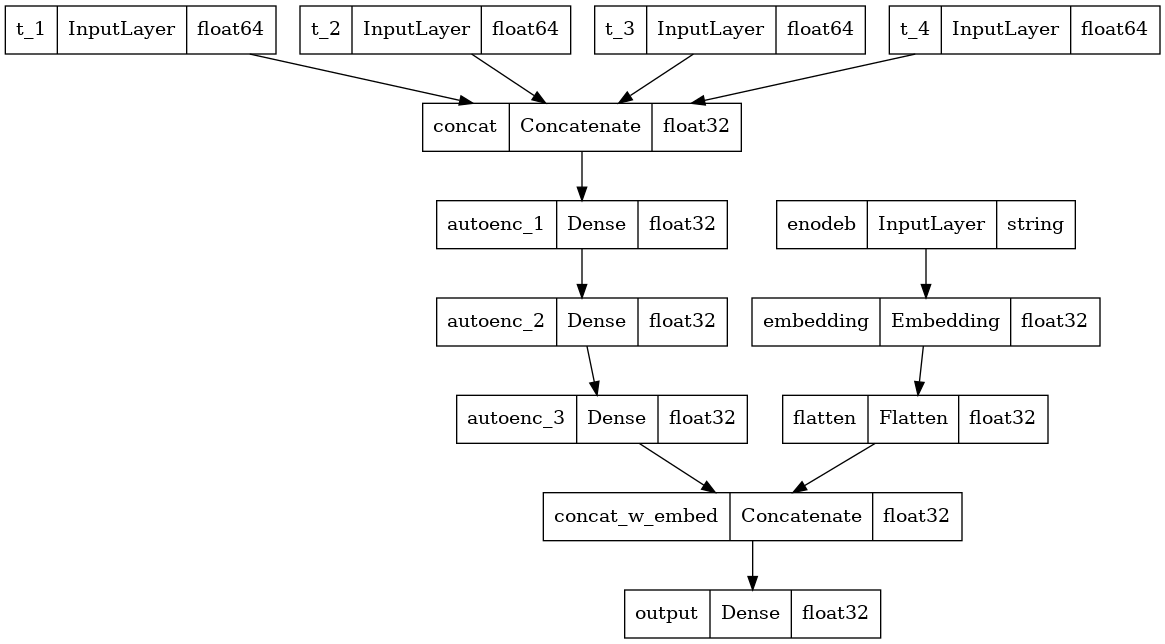

In [14]:
tf.keras.utils.plot_model(autoencoder, show_dtype=True)

In [15]:
batch_size=5

In [16]:
history = autoencoder.fit(training_ds,
                        epochs=3,
                        # validation_data=(test_array, test_array), 
                        batch_size=batch_size) #,
                        #shuffle=True,
                        #callbacks=[reduce_lr, model_checkpoint_callback])

Epoch 1/3


2022-06-17 18:03:13.849641: W tensorflow/core/framework/op_kernel.cc:1722] OP_REQUIRES failed at cast_op.cc:121 : UNIMPLEMENTED: Cast double to string is not supported


UnimplementedError: Graph execution error:

Detected at node 'model/Cast_1' defined at (most recent call last):
    File "/opt/conda/lib/python3.7/runpy.py", line 193, in _run_module_as_main
      "__main__", mod_spec)
    File "/opt/conda/lib/python3.7/runpy.py", line 85, in _run_code
      exec(code, run_globals)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/opt/conda/lib/python3.7/site-packages/traitlets/config/application.py", line 972, in launch_instance
      app.start()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 712, in start
      self.io_loop.start()
    File "/opt/conda/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 541, in run_forever
      self._run_once()
    File "/opt/conda/lib/python3.7/asyncio/base_events.py", line 1786, in _run_once
      handle._run()
    File "/opt/conda/lib/python3.7/asyncio/events.py", line 88, in _run
      self._context.run(self._callback, *self._args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 504, in dispatch_queue
      await self.process_one()
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 493, in process_one
      await dispatch(*args)
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 400, in dispatch_shell
      await result
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 724, in execute_request
      reply_content = await reply_content
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 387, in do_execute
      cell_id=cell_id,
    File "/opt/conda/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
      raw_cell, store_history, silent, shell_futures, cell_id
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3029, in _run_cell
      return runner(coro)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
      interactivity=interactivity, compiler=compiler, result=result)
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3472, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_15809/1268800415.py", line 4, in <module>
      batch_size=batch_size) #,
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 452, in call
      inputs, training=training, mask=mask)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 571, in _run_internal_graph
      y = self._conform_to_reference_input(y, ref_input=x)
    File "/opt/conda/lib/python3.7/site-packages/keras/engine/functional.py", line 671, in _conform_to_reference_input
      tensor = tf.cast(tensor, dtype=ref_input.dtype)
Node: 'model/Cast_1'
Cast double to string is not supported
	 [[{{node model/Cast_1}}]] [Op:__inference_train_function_1081]